# Big Data Analysis Project - Group Project FS2020
## University of Zurich
## 5th of June 2020

Jara Fuhrer, 15-702-889

Claudio Brasser,

Severin Siffert, 14-720-536

Andrea Giambonini, 10-726-842

Elizabeth Oladipo, 17-722-414


## "The goal of the project is to apply the data science pipeline"

![title](doingDS.png)

# Data Collection / Acquisition

Our dataset comes from http://www.kave.cc/, where 15'000 hours of interaction data from the Visual Studio plugin ReSharper (a popular tool to program in C#) was collected in almost 11 million events from voluntaries.
To see what kind of data is collected, you can look at the data schema here: http://www.kave.cc/feedbag/event-generation.

Within this project, we focus on three events:
- build event: actions like build, build all, or clean
- edit event: changes made by the developer, like renaming
- test run event: which tests where run when and with what result


#### Who constructed data set, when, why?
The KaVE Project originally was a German research program. Over the past 10 years, it evolved into a platform for research around recommendation systems for software engineering. Generally, they're interested in questions like how humans influence software engineering or how certain tools can support humans to better / more efficiently perform their tasks. 
Examples are intelligent code completion, interaction trackers or evaluation tools.

The KaVE are collecting and providing these data sets such that we can better understand what software engineers do / what they interact with / where their problems lie. With this data, we can try to see relations between the working behaviour of developers and his efficienty / performance / productivity / habits etc.

Below, the three data sets we extracted from the gigantic pile of possibilities are explained.

#### What do we want to learn from this data?
From personal experience, we know how important it is to frequently build your code and run some tests. Only then you're able to link what you've done (i.e. what you've written, the edit events) to the outcome (i.e. (hopefully) working code, build and test run events). 

* often repeated advice: compile early, compile often
* intuition: longer time and more edits between tests/builds = more chance to screw up
* Is there a way to show that empirically?

Our goal of this data analysis therefore is to analyze the link between the probability of Unit tests or project builds succeeding in connection with how much time has passed and how many edits were made since the last build/test run.


#### Hypotheses

We want to test the advice 'compile early, compile often' and the closely related 'test a lot' empirically. In order to do this we found three relevant events in the data: edit (code modified), build and test events.

Our hypotheses are:

1. Build
    * the longer a developer waits to build his code, the higher the probability that the build will fail
    * the more edit events a developer executes, the lower the probability that the build will succeed
2. Test   
    * the longer a developer waits to run some tests, the higher the probability for test failures
    * the more edit events a developer executes, the lower the probability for test success


#### Final Data Analysis Questions:
1) linking time since last (successful?) build to probability of build succeeding -- SEVERIN

2) linking time since last tests run to probability of tests passing -- ELIZABETH

3) linking number of edit events since last successful build to probability of build succeeding -- ANDREA

4) linking number of edit events since last passing tests to probability of unit tests passing -- JARA

# Data Preprocessing / Cleaning --> TODO Claudio

The data was originally available in individual json events, with great support for parsing with Java or C#. 
Using the accompanying Java examples we converted the JSON-formatted data into .csv files in order to have an easy import into Pandas Dataframes available.
This resulted in a dataset consisting out of 3 different files, one for each type of event.

The more simple part of the preprocessing stage included discarding wrong, incomplete, and unneeded data, parsing timestamps into a Python-compatible format, and storing the data into new, cleaned csv files. 

## Session Splitting

The main challenge in the preprocessing stage turned out to be session splitting. In our dataset, each record describes an <i>event</i> in the IDE, triggered by a programmer. Now each event also contains a *sessionID* attribute. This attribute will be the same for each event triggered without the progammer closing his IDE or even shutting down his computer. So naturally, a session could range from a few minutes duration (e.g. if the programmer restarts his computer right away) to really long timespans. We could tell that some programmers close their IDE only for forced Windows updates. 
Because we want to track actual development time, we decided to call it a new session if no code was modified for five minutes. We did this by introducing a variable called `SESSION_TIMEOUT_SECONDS = 300`, which denotes how long a session can be kept alive without any events triggered by the programmer.

For this splitting of sessions to work, all 3 data files have to be considered and upon finding a session that needs to be split, all records from the same session with a timestamp greater than the splitting point will have to be split as well.

Example:


---


SESSION_TIMEOUT_SECONDS = 60

record A: sessionID = 1, timestamp = 05.05.2020 - 16:00:00 - edit

record B:  sessionID = 1, timestamp = 05.05.2020 - 16:00:30 - edit

record C:  sessionID = 1, timestamp = 05.05.2020 - 18:00:00 - build

record D:  sessionID = 1, timestamp = 05.05.2020 - 18:00:45 - test


---


In this example, the first two edit events clearly belong to the same session, as the follow 30 seconds after one another. Record C has a timestamp much later in the day though. When our algorithm arrives at record C, it will assign a newly generated (unique) sessionID to the record because `recordC.timestamp - recordB.timestamp > SESSION_TIMEOUT_SECONDS`. Additionally, record D will still have the timestamp of the original sessionID assigned to it, which is now wrong since we split the session up beforehands. This means that we will have to find all events *after* the splitting point and assign the new ID to them as well.

This Notebook only imports the data after this cleanup has happened.

In [60]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
from itertools import islice
from sklearn import datasets, linear_model, model_selection, metrics
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.tools.tools as sm
import statsmodels.api as sm1
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE


In [3]:
df_edit = pd.read_csv(r'..\data\df_edit.csv', low_memory=False)
df_test = pd.read_csv(r'..\data\df_test.csv', low_memory=False)
df_build = pd.read_csv(r'..\data\df_build.csv', low_memory=False)

# Data Exploration

Each row in our dataset is a sessionID-timestamp pair for the respective event category (build, test or edit). For Build events we know in addition if the event succeded or not (boolean) and for test events we know how many unit test were run at a specific time and how many of those succeded.

Let's take a look at the data:

### Edit Events

Edit events are triggered whenever code gets modified in some way. This covers typing on the keyboard, using refactoring tools and executing commands that change the code. For example if I copy/paste a line, that triggers an edit event, just like when I auto generate a bunch of getters and setters.

In [4]:
print(f' This dataset contains {len(df_edit)} edits events')
df_edit.iloc[:,1:].tail()

 This dataset contains 497459 edits events


,sessionID,timestamp,type
497454,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:31:53,edit
497455,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 14:47:53,edit
497456,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 14:48:02,edit
497457,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 14:48:12,edit
497458,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 14:48:20,edit


### Test Events

Test events are written whenever the button to run unit tests is clicked. The events record the timing, how many tests were executed, and how many actually succeeded. Test events that have 0 tests run can happen when no tests are selected to run or when test execution is cancelled before the first one completes.

In [5]:
print(f' This dataset contains {len(df_test)} test events.','\n',f'SessionID-timestamp run, in average, {round(df_test.iloc[:,4].mean(),1)} tests and in average over all sessionID-timestamp pair, {round((df_test.iloc[:,5].mean()/df_test.iloc[:,4].mean())*100,1)}% are "passed" tests.')
df_test.iloc[:,1:].tail()

 This dataset contains 3826 test events. 
 SessionID-timestamp run, in average, 88.8 tests and in average over all sessionID-timestamp pair, 86.3% are "passed" tests.


,sessionID,timestamp,type,totalTests,testsPassed
3821,fa4a1e32-d8a9-4fce-a57e-0aec4d6a25bc,2016-09-22 13:45:37,test,478.0,0.0
3822,fa4a1e32-d8a9-4fce-a57e-0aec4d6a25bc,2016-09-22 13:46:16,test,478.0,475.0
3823,fadb490b-cc30-4690-8ecd-ae5c818fb1e1,2016-08-31 11:57:20,test,92.0,92.0
3824,fbcdffc5-b444-4262-bbb6-52c091caea79,2016-07-17 12:18:13,test,0.0,0.0
3825,ff816b40-f797-4065-a6ef-94abb564e92c,2016-12-20 10:48:00,test,0.0,0.0


### Build Events

Build events are triggered whenever some part of the code is compiled. This is usually before running tests, before running the program, and before starting a debugging session.

In [6]:
print(f' This dataset contain {len(df_build)} build events.','\n',f'In average, {round(len(df_build.loc[df_build["buildSuccessful"]==True])/len(df_build)*100,1)}% are succeddful build.')
df_build.iloc[:,1:].tail()

 This dataset contain 14957 build events. 
 In average, 86.2% are succeddful build.


,sessionID,timestamp,type,buildSuccessful
14952,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:01:13,build,False
14953,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:01:32,build,True
14954,ff7bee9b-075d-4139-b782-65d1587da5c9,2016-10-18 09:43:34,build,True
14955,ff9890a9-60d7-41f5-a655-95527ee6f4b7,2016-11-21 14:07:51,build,False
14956,ffb030c9-c0ff-42bd-9e04-6c4b44f5ab79,2016-05-10 16:14:55,build,True


Unfortunately, we are not yet ready to build our model. In order to test our hypotheses we need to reprocess the data to find:
1. the time passed between two build/test events
2. the number of edits between build/test events

## Processing the data in order to predict Build success

The first reflection to do is about which session should be consider in our analysis. We are interested in what happens between two consecutives events, but should we consider any subsequent build events?
We decided to only consider what happens from a successful build to the next build. The reason for this choice is that we want to start from a 'stable' state and analyze how the probability of obtaining another stable state (i.e. Successful Build) is affected by how much changes we made. If we didn't start from a 'stable' state, our result might be biased by other changes in the past which made the state 'unstable' (not passed Build).

Now we can start processing our Data as follow:

* For each sessionID:
    1. get timestamp of the last successfull build
    2. get timestamp of next build after 1)
        * if there is a 2) > 1) then:
    3. get the time passed between 1) and 2)
    4. count number of edits between the timestamp 1) and 2)
        * else we dont take 1) into account
* Create a new DataFrame with following variables:
    - sessionID
    - timestamp of the successful Build event
    - timestamp of the next Build event (next build after the successful Build event)
    - time passed between the successful Build and the next Build event (in seconds)
    - edits between the successful Build and the next Build event
    - result of the next (after a successful Build) build event (boolean)


In [7]:
def get_all_build(sessionID):
    all_build = df_build[df_build["sessionID"] == sessionID]
    return all_build.sort_values(["timestamp"]).values

In [8]:
def get_successful_build(sessionID):
    all_successful_build = df_build[(df_build["sessionID"] == sessionID) & (df_build["buildSuccessful"] == True)] 
    return all_successful_build.sort_values(["timestamp"]).values

In [9]:
def get_nr_edits_between_build(sessionID,timeLastSuccessfullBuild, timeNextBuild):
    totalEdit = df_edit[df_edit["sessionID"] == sessionID]
    totalEdit = totalEdit.sort_values(["timestamp"])
    editBetweenSuccessBuildAndBuild = totalEdit[(totalEdit["timestamp"] <= timeNextBuild) & (totalEdit["timestamp"] >= timeLastSuccessfullBuild)]
    return editBetweenSuccessBuildAndBuild["timestamp"].values.size

In [10]:
def edits_from_pass_to_next_build(sessionID):
    result = []

    # get all successful build of session 
    allSuccessfulBuild = get_successful_build(sessionID)
    allBuild = get_all_build(sessionID)
    numOfSuccessfulBuild = np.size(allSuccessfulBuild,0)
    numOfBuild = np.size(allBuild,0)
    # iterate over each passed build
    for s in range(numOfSuccessfulBuild):
        # if build follows, count edits
        if allBuild[-1][2]>allSuccessfulBuild[s][2]:
            for b in range(numOfBuild):
                if allBuild[b][2]>allSuccessfulBuild[s][2]:
                    break
                    
            timeLastSuccessfulBuild=allSuccessfulBuild[s][2]
            timeNextBuild=allBuild[b][2]
            resultNextBuild=allBuild[b][4]
            nrOfEdit=get_nr_edits_between_build(sessionID,timeLastSuccessfulBuild, timeNextBuild)
            sessionID = allBuild[b][1]
            time_passed = pd.Timedelta(datetime.strptime(timeNextBuild, '%Y-%m-%d %H:%M:%S')-datetime.strptime(timeLastSuccessfulBuild, '%Y-%m-%d %H:%M:%S')).seconds
            if nrOfEdit==0:
                pass
            else:
                result.append([sessionID, timeLastSuccessfulBuild, timeNextBuild, time_passed, nrOfEdit, resultNextBuild])
            
    return result

In [11]:
#Iterate over all sessions and create DataFrame
final_result=[]
allSessionID=df_build.sessionID.unique()
print(f'time before loop: {datetime.now(tz=None)} \n')
# get edits_from_pass_to_next_build for all sessionID
for sessionID in allSessionID:
    Observations = edits_from_pass_to_next_build(sessionID)
    NrOfObservations = len(Observations)
    # take only sessionID with at least 1 successful build and at least 1 build after that  
    if NrOfObservations > 0:
        for Obs in Observations:
            final_result.append(Obs)
print(f'time after loop: {datetime.now(tz=None)} \n')

time before loop: 2020-06-01 10:19:28.055514 

time after loop: 2020-06-01 10:24:56.680288 



In [12]:
#create DataFrame
column_labels = ['sessionID','timestampSuccessBuild','timestampNextBuild','time_passed', '#editsUntilNextBuild', 'nextBuildResult']
new_df_build = pd.DataFrame(final_result, columns=column_labels)
#show the new DataFrame
new_df_build.tail()

,sessionID,timestampSuccessBuild,timestampNextBuild,time_passed,#editsUntilNextBuild,nextBuildResult
9557,fe8caa7d-fbb6-494c-aedb-ecbf22ff8a91,2016-07-25 18:17:02,2016-07-25 18:20:21,199,18,True
9558,fe8caa7d-fbb6-494c-aedb-ecbf22ff8a91,2016-07-25 18:20:21,2016-07-25 18:22:36,135,12,True
9559,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:00:06,2016-04-02 22:00:28,22,5,True
9560,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:00:28,2016-04-02 22:00:47,19,2,True
9561,fef6f3d6-3a5f-4f7c-8ddf-b52346a831c5,2016-04-02 22:00:47,2016-04-02 22:01:13,26,5,False


In [13]:
new_df_build.isnull().any()

sessionID                False
timestampSuccessBuild    False
timestampNextBuild       False
time_passed              False
#editsUntilNextBuild     False
nextBuildResult          False
dtype: bool

##### Further data exploration
Now that we have our final dataset we can explore our data better. First, we look at the distribution of how many builds actually succeed and how often builds happen.

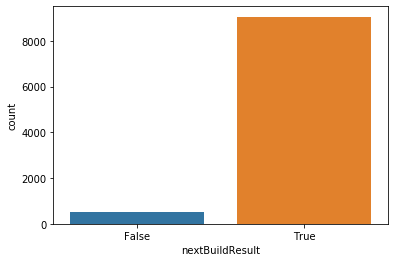

Only 5.3% of the build-events fail


In [14]:
sns.countplot(x="nextBuildResult",data=new_df_build)
plt.show()
count_failedBuild = len(new_df_build[new_df_build["nextBuildResult"]==False])
count_passedBuild = len(new_df_build[new_df_build["nextBuildResult"]==True])
pct_failedBuild = round(count_failedBuild/(count_failedBuild+count_passedBuild)*100,1)
print(f'Only {pct_failedBuild}% of the build-events fail')

In [15]:
new_df_build.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","median","max","min"],"time_passed":["count","mean","median","max","min"]})

#editsUntilNextBuild                            time_passed  \
                               count       mean median  max min       count   
nextBuildResult                                                               
False                            507  19.879684      8  249   1         507   
True                            9055  12.329652      6  286   1        9055   

                                              
                       mean median   max min  
nextBuildResult                               
False            248.238659    117  2082   1  
True             160.658421     81  2879   1

First remarks:
* Our classes (successful vs. unsuccessful Build events) are strongly imbalanced.
* The average number of edits and the average time passed for unsuccessful Build are more then twice as much as for successful Build. This seems to support our hypothesis.
* However our variable "number of edits" and "time passed" between builds events are strongly positive skewed.
* We did not expect builds to happen that often. We have a mean of less than 2 minutes between builds, which might also explain why many builds succeed.

Let's try to visualize the timings

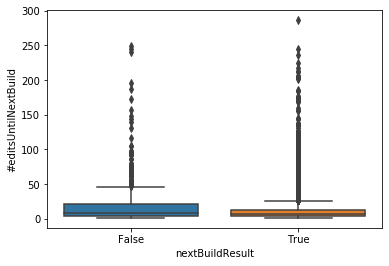

In [16]:
sns.boxplot(x=new_df_build["nextBuildResult"], y=new_df_build["#editsUntilNextBuild"])

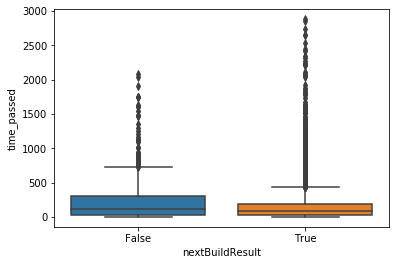

In [17]:
sns.boxplot(x=new_df_build["nextBuildResult"], y=new_df_build["time_passed"])

This Bloxplot representation show us that many datapoint are recognize as possible outliers. Let's try to consider only observation with at most 100 edits and less than 1200 seconds between Build event to remove some of the noise.

96.1% of the unsuccessful build events have less than 101 edits and less then 20 min between the two Build events
98.8% of the successful build events have less than 101 edits and less then 20 min between the two Build events


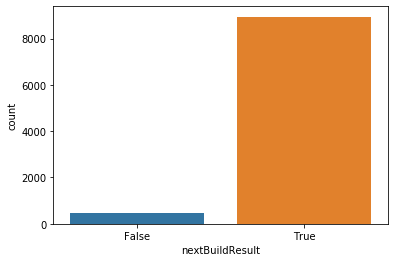

Only 5.2% of the build-events fail if we consider this restricted dataset.


In [18]:
new_df_build1=new_df_build.loc[(new_df_build["#editsUntilNextBuild"]<100) & (new_df_build["time_passed"]<1200)]
print(f'{round(len(new_df_build1[new_df_build1["nextBuildResult"]==False])/len(new_df_build[new_df_build["nextBuildResult"]==False])*100,1)}% of the unsuccessful build events have less than 101 edits and less then 20 min between the two Build events')
print(f'{round(len(new_df_build1[new_df_build1["nextBuildResult"]==True])/len(new_df_build[new_df_build["nextBuildResult"]==True])*100,1)}% of the successful build events have less than 101 edits and less then 20 min between the two Build events')

sns.countplot(x="nextBuildResult",data=new_df_build1)
plt.show()
count_failedBuild = len(new_df_build1[new_df_build1["nextBuildResult"]==False])
count_passedBuild = len(new_df_build1[new_df_build1["nextBuildResult"]==True])
pct_failedBuild = round(count_failedBuild/(count_failedBuild+count_passedBuild)*100,1)
print(f'Only {pct_failedBuild}% of the build-events fail if we consider this restricted dataset.')

Given that we already considered possible problems within sessionID and we already splitted many sessionID using our session_timeout indicator, we don't see any reasonable reasons to further restrict our dataset. Therefore we decided to continue our analysis with the whole dataset.  

## Process the data in order to predict the probability of a successful test 

For the analysis of the relationship between the A) number of edits done or B) the time passed between two tests and the success of a test, we again want to have this "stable" state: We only consider the number of edits done after a successful test. Sessions that have zero passed tests won't be analyzed.

Now, the question arose how to define a "successful" test. There are two possibilities:
- a test run is successful if all the tests were successful, i.e. passedTests over totalTests equals to 1
- a test run is successful if at least 1 test was successful, i.e. passesTests over totalTests lies between 0 and 1

We decided on classifying a test run only successful when 100% of the tests passed. With the second definition, the spectrum of a successful test would be too big (a test run with 5% passed tests would be considered just as successful as a test run with 100%). This decision of calling a test successful with 100% passing tests also goes along well with the definition of a successful build (there are no partial successful builds).

In order to predict the probability of a successful test run, we need the two data sets "df_edit" and "df_test". The latter has a column "testsPassed" which gives us the information whether to consider a particular session or not: It has to be equal to the total numbers of tests run such that it reached this 100% passed tests.


To process our data, we defined several auxiliary functions which generally speaking do the following:

* For each sessionID:
    - get all entries that have passed tests, i.e. that have testsPassed > 0
* For each sessionID with a passed test:
    - count the number of edits done until the next test run
    - here, we don't differentiate passed or failed tests, since that's exactly what we're interested in. 
* Create a new DataFrame with the following variables:
    - sessionID
    - timeTestPass: timestamp when a test passed
    - timeNextTest: timestamp of the next test run of this sessionID
    - editsUntilNextTest: number of edits done from timePass until timeNext
    - ratio_p_t: result of the next test run. Ratio = passedTestNext/totalTestsNext, i.e. the percentage of passed tests
    - totalTestsNext: total tests run in the next test (which was at timeNext)
    - testPassedNext: number of tests passed in the next test (which was at timeNext)
    - nextTestResult: boolean which is true if 100% of the tests passed = test was successful, otherwise false


#### But first, before the processing, let's have a look at the df_test data set

Let's take a look at the relations between totalTests and testsPassed.

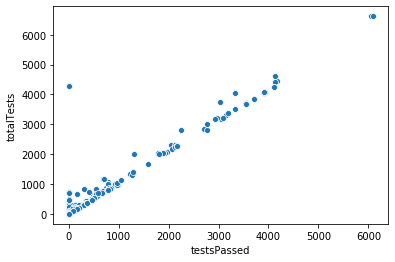

In [20]:
sns.scatterplot(x="testsPassed",y = "totalTests",data=df_test)

The relationship between total tests and passed tests is positive linear. It is a rather strong correlation --> TODO maybe include r value? This shows that most of the data has a 100% passed-test score.

In terms of outliers, there are only a few on the left side in the middle.

This graph makes sense to us: Generally speaking, the number of passed tests should in the worst case stay the same, in the better case increase as the number of total tests goes up. 

A decreasing ratio of passedTests to totalTests (i.e. more and more tests fail) would indicate that the more tests you run, the more errors you detect in your code.

Of course there is also the invariant of `Tests run >= Tests passed`.

### Now, let's process the data
Count the number of edits since last successful tests run

In [23]:
# gets all passed tests for a particular sessionID
def get_passed_tests(sessionID):
    allPassedTests = testEvents[(testEvents["sessionID"] == sessionID) 
                        & (testEvents["testsPassed"] == testEvents["totalTests"] )]
    return np.asarray(allPassedTests)

# counts the numbers of edits between a test and the next test
# for our purpose, be aware to only call it with passed tests
def get_nr_edits_between_tests(sessionID, timeFirstTest , timeNextTest):
    result = df_edit[(df_edit["timestamp"] < timeNextTest)
                                 & (df_edit["timestamp"] > timeFirstTest) 
                                 & (df_edit["sessionID"] == sessionID)]
    result = np.asarray(result)
    return len(result)

# counts nr of edits between all the test runs of a particular sessionID
def edits_from_pass_to_next_test(sessionID):
    result = []
    resultRow = []
    # get all passed tests of the session 
    allPassedTests = get_passed_tests(sessionID)

    numOfRows = np.size(allPassedTests, 0)
    # iterate over each passed test
    for p in range(numOfRows):
        timePass = allPassedTests[p][2]

        # no following test
        if p == numOfRows-1:
            hasNextTest = False
        else:
            hasNextTest = True
            timeTestNext = allPassedTests[p+1][2]
            resultNext = allPassedTests[p+1][4]

        # for each passed test, get nr of edits until next test
        if hasNextTest:
            nrOfEdits = get_nr_edits_between_tests(sessionID,timePass, timeTestNext)
            print(f'time of pass to append: {timePass}')
            print(f'nr of edits: {nrOfEdits}')
            print(f'result next: {resultNext} \n')
            result.append([sessionID, timePass, timeTestNext, nrOfEdits, resultNext])
            
    return result

Create a DataFrame with 9 columns

In [232]:
def create_df(resultArray):
    # Create DataFrame
    column_labels = ['sessionID','timeTestPass','timeNextTest','timePassed','editsUntilNextTest', 
                     'ratio_p_t','totalTestsNext', 'testPassedNext' ,'nextTestResult']
    df = pd.DataFrame(resultArray, columns=column_labels)
    return df;

#### Now iterate over all sessions and create a DataFrame

In [223]:
# Creates a DF and returns a list that contains among other things
# the nr of edits from a passing test until the next test event and whether this next test has been successful
def get_edits_tests_list():
    sessionWithPassedTests=0
    sessionWithoutPassedTests=0
    sessionWithPassedTestsButNoNextTest=0
    result=[]
    for index, row in df_test.iterrows():
        if(row["testsPassed"] > 0):
            sessionWithPassedTests+=1
            #has next test
            if((index+1 < len(df_test)) and (df_test.iloc[index+1].sessionID == row["sessionID"])):
                item=[]
                timestampNext=df_test.iloc[index+1].timestamp
                time_passed = pd.Timedelta(datetime.strptime(timestampNext, '%Y-%m-%d %H:%M:%S')
                                           -datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S')).seconds
                totalTestsNext=df_test.iloc[index+1].totalTests
                passedTestNext=df_test.iloc[index+1].testsPassed
                nrOfEdits=get_nr_edits_between_tests(row["sessionID"], row["timestamp"], timestampNext)
                if(passedTestNext == 0):
                    resultTestNextBoolean = 0
                else:
                    resultTestNextBoolean = 1
                if(totalTestsNext != 0):
                    ratioPT = (passedTestNext/totalTestsNext)
                else:
                    ratioPT = 1
                item.append(row["sessionID"])
                item.append(row["timestamp"])
                item.append(timestampNext)
                item.append(time_passed)
                item.append(nrOfEdits)
                item.append(float(ratioPT))
                item.append(int(totalTestsNext))
                item.append(int(passedTestNext))
                item.append(int(resultTestNextBoolean))
                result.append(item)
            else:
                sessionWithPassedTestsButNoNextTest+=1
        else:
            sessionWithoutPassedTests+=1
    print(f'SessionIDs with passed tests: {sessionWithPassedTests}')
    print(f'SessionIDs with passed test but no next test: {sessionWithPassedTestsButNoNextTest}')
    print(f'SessionIDs without passed test: {sessionWithoutPassedTests}')
    
    return result

In [224]:
edits_tests= get_edits_tests_list()

SessionIDs with passed tests: 2565
SessionIDs with passed test but no next test: 549
SessionIDs without passed test: 1261


In [233]:
df_edits_tests = create_df(edits_tests)
df_edits_tests.head(10)

,sessionID,timeTestPass,timeNextTest,timePassed,editsUntilNextTest,ratio_p_t,totalTestsNext,testPassedNext,nextTestResult
0,158,2016-07-13 18:49:28,2016-07-13 18:51:53,145,15,1.0,21,21,1
1,158,2016-07-13 18:51:53,2016-07-13 18:53:04,71,3,1.0,21,21,1
2,158,2016-07-13 18:53:04,2016-07-13 18:53:20,16,1,1.0,21,21,1
3,158,2016-07-13 18:53:20,2016-07-13 18:53:27,7,0,1.0,21,21,1
4,158,2016-07-13 18:53:27,2016-07-13 18:53:55,28,1,1.0,21,21,1
5,158,2016-07-13 18:53:55,2016-07-13 18:54:54,59,6,1.0,21,21,1
6,158,2016-07-13 18:54:54,2016-07-13 18:55:50,56,3,1.0,21,21,1
7,158,2016-07-13 18:55:50,2016-07-13 18:57:15,85,1,1.0,21,21,1
8,158,2016-07-13 18:57:15,2016-07-13 19:02:13,298,1,1.0,21,21,1
9,158,2016-07-13 19:02:13,2016-07-13 19:03:28,75,5,1.0,21,21,1


### Now that we have our processed data set, we can analyze the data further

#### Explore the processed data edits_tests

Let's have a look a the "nextTestResult" value, which says whether or not a test run after a successful test was successful too = 100% passed-test score.

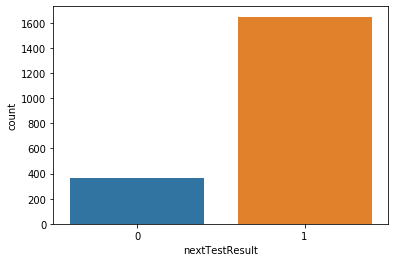

18.3% of the tests events fail. 81.7% were successful.


In [116]:
sns.countplot(x="nextTestResult",data=df_edits_tests)
plt.show()
count_failedTests = len(df_edits_tests[df_edits_tests["nextTestResult"]==False])
count_passedTests = len(df_edits_tests[df_edits_tests["nextTestResult"]==True])
pct_failedTests = round(count_failedTests/(count_failedTests+count_passedTests)*100,1)
print(f'{pct_failedTests}% of the tests events fail. {100-pct_failedTests}% were successful.')

This distribution can also be explored by a histogram:

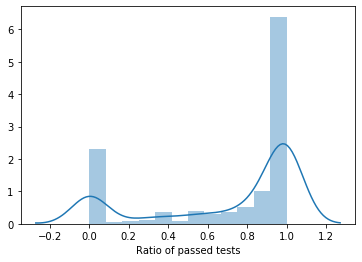

In [155]:
sns.distplot(df_edits_tests.ratio_p_t,
             axlabel='Ratio of passed tests')

The histogram doesnt show a normal distribution. The data is rather left skewed, i.e. most of the samples are clustered on the right side. However, the long tail on the left gets "interrupted". 

Let's therefore take a closer look at the extreme on the left, where the ratio is 0.


We know from the processing done before (in the get_edits_tests_list) that we regard a test run with zero tests as successful. Therefore, a ratio of 0 can only occur when 0 tests passed within a test run.

In [238]:
count_0tests = len(df_edits_tests[df_edits_tests["totalTestsNext"]==0])
print(f'Number of test runs with 0 tests: {count_0tests}')

Number of test runs with 0 tests: 11


It's interesting to see the distribution of the result when only 1 single test is run. Because in this case, the ratio either can be 0 or 1 - our two extremes.

In [259]:
count_totalFailedTests = len(df_edits_tests[df_edits_tests["nextTestResult"]==0])
print(f'In total, {count_totalFailedTests} test run failed.\n')

count_totalTestsNext0or1 = len(df_edits_tests[df_edits_tests["totalTestsNext"] == 1])
count_failedOnly1 = len(df_edits_tests[(df_edits_tests["totalTestsNext"] == 1) 
                        & (df_edits_tests["nextTestResult"] == 0 )])
count_failedMoreThan1 = len(df_edits_tests[(df_edits_tests["totalTestsNext"] > 1 ) 
                        & (df_edits_tests["nextTestResult"] == 0 )])
total_test_runs = len(df_edits_tests)

print(f'In total, there are {count_totalTestsNextOnly1} test runs which contain 1 single test ({round(count_totalTestsNextOnly1/total_test_runs,2)*100}%).\n')
print(f'Out of these {count_totalTestsNextOnly1} runs, {count_failedOnly1} tests, {round(count_failedOnly1/count_totalTestsNextOnly1,2)*100}%, failed.\n')
print(f'This means that {round(count_failedOnly1/count_totalFailedTests, 2)*100}% of the failed test come from test runs which contain only 1 single test.') 


In total, 368 test run failed.

In total, there are 641 test runs which contain 1 single test (32.0%).

Out of these 641 runs, 299 tests, 47.0%, failed.

This means that 81.0% of the failed test come from test runs which contain only 1 single test.



The fact that approximately one third of the test runs include only one test partially explains the two hîgher bins on the left and right side of the histogram: If there is only one test run, the ratio of passed tests can only be 1 or 0. 

This histogram furthermore indicates that mostly related tests were run. Otherwise, we would see way more samples that lie inbetween 0 and 1.

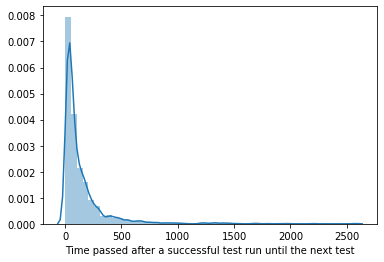

In [260]:
sns.distplot(df_edits_tests.timePassed,
             axlabel='Time passed after a successful test run until the next test')

The histogram of the time passed between two tests is right skewed. For most of the samples, the time passed is between 0 and 5000 seconds. Later on, we see more concrete values.

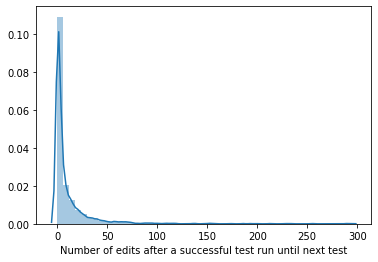

In [83]:
sns.distplot(df_edits_tests.editsUntilNextTest,
             axlabel='Number of edits after a successful test run until next test')

Just as the time passed, the number of edits between two tests is righ skewed too.

Let's look at the distribution of the number of edit events and time passed with regard to the percentage of pasesd tests.

Text(0, 0.5, 'number of edits')

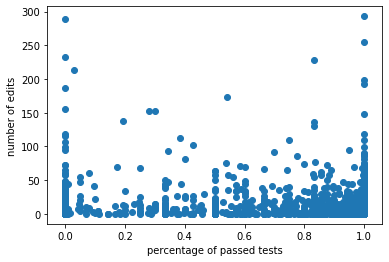

In [267]:
edits_tests_array = np.array(edits_tests, dtype="O")

x = edits_tests_array[:,4] # nr of edits
y = edits_tests_array[:,5] # ratio

plt.scatter(y,x)
plt.xlabel('percentage of passed tests') 
plt.ylabel('number of edits') 


Text(0, 0.5, 'number of edits')

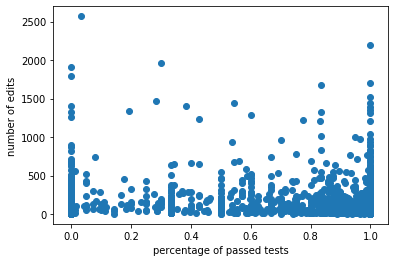

In [269]:
x = edits_tests_array[:,3] # timepassed
y = edits_tests_array[:,5] # ratio

plt.scatter(y,x)
plt.xlabel('percentage of passed tests') 
plt.ylabel('number of edits') 


We see that the both scatterplots look very similar. How does their relation to each other look like?


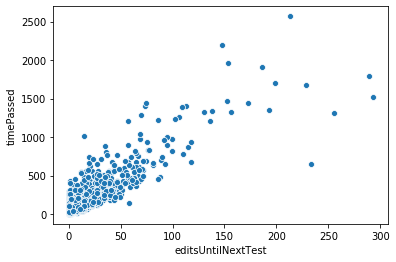

In [274]:
sns.scatterplot(x="editsUntilNextTest", y ="timePassed", data=df_edits_tests)

We can identify a positive correlation. Which is reasonable: The more edits a developer performs, the more time passes until a new test run is started. We can therefore expect that both time passed and edits between two test runs will have a similar influence on whether or not the next test run succeeds.

##### Means of ratio, edits and time passed

In [261]:
ratio_p_t_mean = df_edits_tests["ratio_p_t"].mean()
pct_ratio_p_t_mean = round(ratio_p_t_mean*100,1)
print(f'The mean ratio of passed tests over total tests is {pct_ratio_p_t_mean}%. This means that in general, over two third of the tests passed within a single test run.\n')

edits_mean = round(df_edits_tests["editsUntilNextTest"].mean(),1)
print(f'On average, {edits_mean} edits were executed before a new test and after a successful test run.\n')


time_passed_mean = round(df_edits_tests["timePassed"].mean(),1)
print(f'The mean time passed between two tests is {time_passed_mean} seconds, so approximately {round(time_passed_mean/60)} minutes.\n')


The mean ratio of passed tests over total tests is 71.4%. This means that in general, over two third of the tests passed within a single test run.

On average, 10.7 edits were executed before a new test and after a successful test run.

The mean time passed between two tests is 142.5 seconds, so approximately 2 minutes.



Lets look closer at the variables we are mostly interested in "editsUntilNextTest" and "timePassed":

In [44]:
df_edits_tests.groupby("nextTestResult").agg({"editsUntilNextTest":["count","mean","median","max","min"],"timePassed":["count","mean","median","max","min"]})

editsUntilNextTest                            timePassed  \
                            count       mean median  max min      count   
nextTestResult                                                            
0                             368  11.440217      1  289   0        368   
1                            1648  10.566748      3  293   0       1648   

                                             
                      mean median   max min  
nextTestResult                               
0               153.798913   68.5  1908   2  
1               139.992718   69.5  2569   3

Before interpreting this, let's look at the distribution of the number of edits by creating a boxplot:

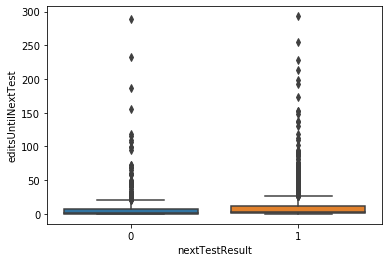

In [262]:
sns.boxplot(x=df_edits_tests["nextTestResult"], y=df_edits_tests["editsUntilNextTest"])

First remarks:
* Our classes (successful vs. unsuccessful Test events) are quite balanced. 
* They have similar mean, max and min values. However, the "True" class has way more samples - almost 5 times more.
* Therefore, a comparison of the two boxplots "fail" and "pass" doesnt reveal a lot of information.
* However, the range/outliers of number of edtis are revealed.
* While the average number of edits for successful tests is 10.6, the aveage for failed test is 11.4
* Also the timePassed between a successful test and the next test is similar for both classes: on average 140 seconds for successful tests, 154 seconds for failed tests.
* Interesting are the median values for the number of edits. Here we see that in 50% of sessions which had unsucessful tests, 0 edits were made until the next test (since median 1). If no changes are made, then it's obvious that the tests will also fail in the next test run. This could indicate that maybe a lot of those failed tests are actually the same one, where the developer didn't change anything to fix the test. We cannot say if the tests run are actually the same tests are before.
* The median of the successful test class (3) surprises us too. It shows that in 50% of the sessions, less than 3 edits were made until the next tests were run. This seems like a highly frequent testing routine.
 * Interesting side note: Other examinations of the data found that there are a few developers (around 15%) that heavily work with Test Driven Development. Lots of tests could stem from this.
* However our variable "number of edits" and "time passed" between builds events are strongly positive skewed.


Let's look at the distribution of the time passed by creating a boxplot:

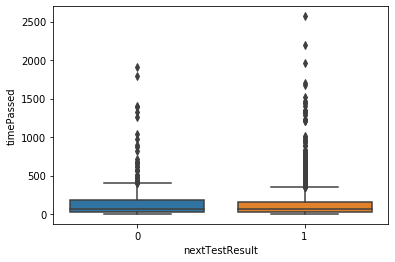

In [263]:
sns.boxplot(x=df_edits_tests["nextTestResult"], y=df_edits_tests["timePassed"])

Just like in the Edits-Test Analysis, this Bloxplot indicates that many datapoint are recognize as possible outliers. We've seen above that on average, only approximately 70 seconds pass until the next test run. However, this plot's y-axis goes up until 2500 seconds! 

We can try to clean this data a bit by excluding sessionIDs with number of edits above 50 and the time passed below 500 seconds. Let's see what happends then:

92.9% of the unsuccessful test events have less than 101 edits and less then 1000 sec / 17min between the two test events
93.9% of the successful test events have less than 101 edits and less then 1000 sec / 17min between the two test events


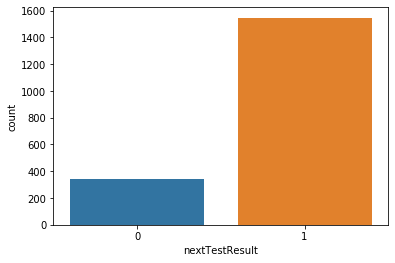

Still 18.1% of the test-events fail if we consider this restricted dataset. For the whole data set this was 18.3%


In [264]:
smaller_df_edits_tests=df_edits_tests.loc[(df_edits_tests["editsUntilNextTest"]<50) & (df_edits_tests["timePassed"]<500)]
print(f'{round(len(smaller_df_edits_tests[smaller_df_edits_tests["nextTestResult"]==False])/len(df_edits_tests[df_edits_tests["nextTestResult"]==False])*100,1)}% of the unsuccessful test events have less than 101 edits and less then 1000 sec / 17min between the two test events')
print(f'{round(len(smaller_df_edits_tests[smaller_df_edits_tests["nextTestResult"]==True])/len(df_edits_tests[df_edits_tests["nextTestResult"]==True])*100,1)}% of the successful test events have less than 101 edits and less then 1000 sec / 17min between the two test events')

sns.countplot(x="nextTestResult",data=smaller_df_edits_tests)
plt.show()
count_failedTest = len(smaller_df_edits_tests[smaller_df_edits_tests["nextTestResult"]==False])
count_passedTest = len(smaller_df_edits_tests[smaller_df_edits_tests["nextTestResult"]==True])
pct_failedTest = round(count_failedTest/(count_failedTest+count_passedTest)*100,1)
print(f'Still {pct_failedTest}% of the test-events fail if we consider this restricted dataset. For the whole data set this was {pct_failedTests}%')



#### Let's plot the new, restricted dataset

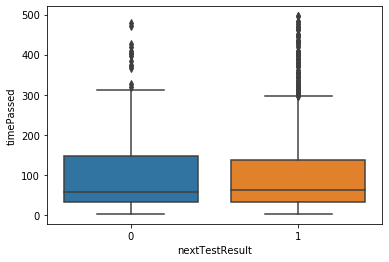

In [265]:
sns.boxplot(x=smaller_df_edits_tests["nextTestResult"], y=smaller_df_edits_tests["timePassed"])

In [266]:
print(f'This small difference in of the failed tests ({round(pct_failedTest -pct_failedTests,1)}% decrease) indicates that the restriction didnt have an influence on the result. Which makes sense since we only excluded some outliers.')

This small difference in of the failed tests (-0.2% decrease) indicates that the restriction didnt have an influence on the result. Which makes sense since we only excluded some outliers.


Hence, we take the first data set, keeping in mind that we have a lot of outliers, and start with building some models!

# Modelling and Algorithm Building

Our goal of this data analysis is to analyze our hypothesis that more time or more edits between build/test events result in a lower probability of build/test succeeding. After having processed and explored the data are we now able to test our two hypothesis:
1. Build
    * the longer a developer waits to build his code, the higher the probability that the build will fail
    * the more edit events a developer executes, the lower the probability that the build will succeed
2. Test   
    * the longer a developer waits to run some tests, the higher the probability for test failures
    * the more edit events a developer executes, the lower the probability for test success

### Build Events

To model the probability of a certain event such as pass/fail the logistic regression is one of the most used model and a good benchmark for further analysis. 

In [27]:
Y = new_df_build["nextBuildResult"]
X = new_df_build[["#editsUntilNextBuild",'time_passed']]
X1 = sm.add_constant(X)
logit_model = sm1.Logit(Y, X1)
result_logit_model = logit_model.fit()
print(result_logit_model.summary2())
print(f' The correlation between the two independent variables is {round(new_df_build["#editsUntilNextBuild"].corr(new_df_build["time_passed"]),2)}')

Optimization terminated successfully.
         Current function value: 0.204575
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.013     
Dependent Variable:  nextBuildResult   AIC:               3918.2899 
Date:                2020-06-01 10:40  BIC:               3939.7865 
No. Observations:    9562              Log-Likelihood:    -1956.1   
Df Model:            2                 LL-Null:           -1982.4   
Df Residuals:        9559              LLR p-value:       3.9802e-12
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                 3.0837   0.0548 56.2993 0.0000  2.9763  3.1910
#editsUntilNextBuild -0.0077

All the coefficients are statistical significant (at 90% confidence level) and both the number of edits and the time passed have a negative effect on the probability of a successful built.  This means that, given the number of edits, the longer a developer waits to build his code, the higher the probability that the build will fail and at the same, given a certain time between two edits events, the more edit events a developer executes, the lower the probability that the build will succeed.


However we can observe that, as expected, the number of edits and the time spent between build events are strongly positively correlated. This Multicollinearity problem can cause unstable estimates in our model and therefore we decided to separately estimate the effect of our independent variable on the probability of a successful build event.

In [106]:
X_edit = new_df_build[["#editsUntilNextBuild"]]
X1_edit = sm.add_constant(X_edit)
logit_model_edit = sm1.Logit(Y, X1_edit)
result_logit_model_edit = logit_model_edit.fit()
print(result_logit_model_edit.summary2())

Optimization terminated successfully.
         Current function value: 0.204732
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.012     
Dependent Variable:  nextBuildResult   AIC:               3919.3014 
Date:                2020-06-01 11:18  BIC:               3933.6325 
No. Observations:    9562              Log-Likelihood:    -1957.7   
Df Model:            1                 LL-Null:           -1982.4   
Df Residuals:        9560              LLR p-value:       1.9960e-12
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                 3.0627   0.0532 57.5246 0.0000  2.9584  3.1671
#editsUntilNextBuild -0.0118

In [107]:
X_time = new_df_build[["time_passed"]]
X1_time = sm.add_constant(X_time)
logit_model_time = sm1.Logit(Y, X1_time)
result_logit_model_time = logit_model_time.fit()
print(result_logit_model_time.summary2())

Optimization terminated successfully.
         Current function value: 0.204974
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.011     
Dependent Variable: nextBuildResult  AIC:              3923.9242 
Date:               2020-06-01 11:18 BIC:              3938.2553 
No. Observations:   9562             Log-Likelihood:   -1960.0   
Df Model:           1                LL-Null:          -1982.4   
Df Residuals:       9560             LLR p-value:      2.1109e-11
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const          3.0682    0.0544  56.3493  0.0000   2.9614   3.1749
time_passed   -0.0009    0.0001  -7.4783  0.0000  -0.0012  -0.

As we can see from this two separate models, now the coefficients are statistical significant even at a 99% confidence level and both the number of edits and the time passed have stronger negative impact on the probability of a successful built. Let's have a brief look at how to interpret this coefficients..

In [108]:
import math
# effect of an increase in the #of edits by 10 units above the median
prSuccBuildwithmedNrEdit=1/(1+math.exp(-(3.0627-0.0118*new_df_build["#editsUntilNextBuild"].median())))*100
prSuccBuildwithmedTime=1/(1+math.exp(-(3.0682-0.0009*new_df_build["time_passed"].median())))*100
print(f'Given a median number of edits, the probability of a successful build is {round(prSuccBuildwithmedNrEdit,1)}%')
print(f'10 edits over the median number of edits, reduce the probability of a successful build by {round(prSuccBuildwithmedNrEdit-1/(1+math.exp(-(3.0627-0.0118*(new_df_build["#editsUntilNextBuild"].median()+20))))*100,1)} percentage points')
# marginal effect of an increase in the #time_passed by 2 minuts above the median
print(f'Given the median time passed between two build events, the probability of a successful build is {round(prSuccBuildwithmedTime,1)}%')
print(f'5 minutes over the median time passed between two build events, reduce the probability of a successful build by {round(prSuccBuildwithmedTime-1/(1+math.exp(-(3.0682-0.0009*(new_df_build["time_passed"].median()+300))))*100,1)} percentage points')

Given a median number of edits, the probability of a successful build is 95.2%
10 edits over the median number of edits, reduce the probability of a successful build by 1.2 percentage points
Given the median time passed between two build events, the probability of a successful build is 95.2%
5 minutes over the median time passed between two build events, reduce the probability of a successful build by 1.4 percentage points


Although they move in the expected (negative) direction, our two independent variables (# of edits and time passed) have a fairly marginal effect on the probability of getting a successful built event. In addition, our two models are not able to explain much of the variability in the dependent variable (very low pseudo R-Squared).

In [109]:
X_train_edit, X_test_edit, Y_train, Y_test = model_selection.train_test_split(X1_edit, Y, test_size=0.1,random_state=0)
logit_model_edit=linear_model.LogisticRegression()
logit_model_edit.fit(X_train_edit, Y_train)

print('Accurancy of logistic regression classifier on test set is :{:.2f}'.format(logit_model_edit.score(X_test_edit,Y_test)))

Accurancy of logistic regression classifier on test set is :0.95


In [110]:
X_train_time, X_test_time, Y_train, Y_test = model_selection.train_test_split(X1_time, Y, test_size=0.1,random_state=0)
logit_model_time=linear_model.LogisticRegression()
logit_model_time.fit(X_train_time, Y_train)

print('Accurancy of logistic regression classifier on test set is :{:.2f}'.format(logit_model_time.score(X_test_time,Y_test)))

Accurancy of logistic regression classifier on test set is :0.95


Despite the not encouraging results of our logistic regressions, we get (from both models) an accurancy of 95%. However, as we saw in the data exploration part, our dataset is strong imbalanced and this may be the main reason for this high accurancy. One approach to adressing this problem of class imbalance is to randomly resample the dataset. Following this approach, we decided to oversample the class of unsuccessful build. 

In [111]:
os = SMOTE(random_state=0)

os_data_X_edit, os_data_Y = os.fit_sample(X_train_edit,Y_train)
os_data_X_edit = pd.DataFrame(data=os_data_X_edit, columns=['constant','#editsUntilNextBuild'])
os_data_Y = pd.DataFrame(data=os_data_Y, columns=['nextBuildResult'])

print("Length of oversampled data is", len(os_data_X_edit))
print("Number of failed Build in oversampled data is", len(os_data_Y[os_data_Y['nextBuildResult']==False]))
print("Number of successful Build is", len(os_data_Y[os_data_Y['nextBuildResult']==True]))
print("Proportion of failed Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==False])/len(os_data_X_edit))
print("Proportion of successful Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==True])/len(os_data_X_edit))

logit_model_edit=sm1.Logit(os_data_Y,os_data_X_edit)
result_logit_edit=logit_model_edit.fit()
print(result_logit_edit.summary2())

Length of oversampled data is 16294
Number of failed Build in oversampled data is 8147
Number of successful Build is 8147
Proportion of failed Build in oversampled data is 0.5
Proportion of successful Build in oversampled data is 0.5


MissingDataError: exog contains inf or nans

In [34]:
os = SMOTE(random_state=0)

os_data_X_time, os_data_Y = os.fit_sample(X_train_time,Y_train)
os_data_X_time = pd.DataFrame(data=os_data_X_time, columns=['constant','time_passed'])
os_data_Y = pd.DataFrame(data=os_data_Y, columns=['nextBuildResult'])

print("Length of oversampled data is", len(os_data_X_time))
print("Number of failed Build in oversampled data is", len(os_data_Y[os_data_Y['nextBuildResult']==False]))
print("Number of successful Build is", len(os_data_Y[os_data_Y['nextBuildResult']==True]))
print("Proportion of failed Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==False])/len(os_data_X_time))
print("Proportion of successful Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==True])/len(os_data_X_time))

logit_model_time=sm1.Logit(os_data_Y,os_data_X_time)
result_logit_time=logit_model_time.fit()
print(result_logit_time.summary2())

Length of oversampled data is 16294
Number of failed Build in oversampled data is 8147
Number of successful Build is 8147
Proportion of failed Build in oversampled data is 0.5
Proportion of successful Build in oversampled data is 0.5


MissingDataError: exog contains inf or nans

In [35]:
# effect of an increase in the #of edits by 10 units above the median
prSuccBuildwithmedNrEdit=1/(1+math.exp(-(0.02235-0.0145*os_data_X_edit["#editsUntilNextBuild"].median())))*100
prSuccBuildwithmedTime=1/(1+math.exp(-(0.2258-0.0011*os_data_X_time["time_passed"].median())))*100
print(f'Given a median number of edits, the probability of a successful build is {round(prSuccBuildwithmedNrEdit,1)}%')
print(f'10 edits over the median number of edits, reduce the probability of a successful build by {round(prSuccBuildwithmedNrEdit-1/(1+math.exp(-(0.02235-0.0145*(os_data_X_edit["#editsUntilNextBuild"].median()+20))))*100,1)} percentage points')
# marginal effect of an increase in the #time_passed by 2 minuts above the median
print(f'Given the median time passed between two build events, the probability of a successful build is {round(prSuccBuildwithmedTime,1)}%')
print(f'5 minutes over the median time passed between two build events, reduce the probability of a successful build by {round(prSuccBuildwithmedTime-1/(1+math.exp(-(0.2258-0.0011*(os_data_X_time["time_passed"].median()+300))))*100,1)} percentage points')

Given a median number of edits, the probability of a successful build is 48.0%
10 edits over the median number of edits, reduce the probability of a successful build by 7.1 percentage points
Given the median time passed between two build events, the probability of a successful build is 52.9%
5 minutes over the median time passed between two build events, reduce the probability of a successful build by 8.2 percentage points


As we can see, with a balanced dataset, the #of edits and the time passed betwenn two build events have a much stronger impact on the probability of a successful build event. Even if the coefficients of our independent variable are almost the same, the coefficient for the intercept has been shrunk. This happened because (previously) the intercept value took into account the unbalanced structure of the dataset in which 95% of the observations were successful build (remember that now only 50% of the observation are successful build events).   

In [36]:
logit_model_edit=linear_model.LogisticRegression()
logit_model_edit.fit(os_data_X_edit, os_data_Y.values)

print('Accurancy of logistic regression classifier on test set:{:.2f}'.format(logit_model_edit.score(X_test_edit,Y_test)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [112]:
logit_model_time=linear_model.LogisticRegression()
logit_model_time.fit(os_data_X_time, os_data_Y.values)

print('Accurancy of logistic regression classifier on test set:{:.2f}'.format(logit_model_time.score(X_test_time,Y_test)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [66]:
Y_pred_edit = logit_model_edit.predict(X_test_edit)
confusion_matrix = metrics.confusion_matrix(Y_test,Y_pred)
print(confusion_matrix)
print(metrics.classification_report(Y_test,Y_pred))

[[ 17  32]
 [208 700]]
             precision    recall  f1-score   support

      False       0.08      0.35      0.12        49
       True       0.96      0.77      0.85       908

avg / total       0.91      0.75      0.82       957



In [70]:
Y_pred_edit = logit_model_edit.predict(X_test_edit)
confusion_matrix_edit = metrics.confusion_matrix(Y_test,Y_pred)
Y_pred_time = logit_model_time.predict(X_test_time)
confusion_matrix_time = metrics.confusion_matrix(Y_test,Y_pred_time)
print('Confusion matrix for the number of edits','\n', confusion_matrix_edit)
print('Metric classification for the number of edits','\n', metrics.classification_report(Y_test,Y_pred_edit))
print('Confusion matrix for the time passed','\n', confusion_matrix_time)
print('Metric classification for the time passed','\n', metrics.classification_report(Y_test,Y_pred_time))


Confusion matrix for the number of edits 
 [[ 17  32]
 [208 700]]
Metric classification for the number of edits 
              precision    recall  f1-score   support

      False       0.08      0.35      0.13        49
       True       0.96      0.79      0.86       908

avg / total       0.91      0.77      0.83       957

Confusion matrix for the time passed 
 [[ 16  33]
 [218 690]]
Metric classification for the time passed 
              precision    recall  f1-score   support

      False       0.07      0.33      0.11        49
       True       0.95      0.76      0.85       908

avg / total       0.91      0.74      0.81       957



As expected, with a balanced dataset, the accuracy of our model has dropped by almost 20 percentage point remaining however at a fair level of 70%.

### Test Events

Now, we want to test those two hypotheses / answer those two questions:

2) linking time since last tests run to probability of tests passing 


4) linking number of edit events since last passing tests to probability of unit tests passing


To model the probability of unit test passing depending on how many edits have been done or how much time has passed between two test runs, we can try a linear regression. Nr of edits or timePassed would be the independent variable X and the ratio Pass/Total, i.e. the probabiltiy of passed tests, the dependent variable Y. 

For this linear regression, we need a 2d array with the numbers of edits and the ratio as well as the time between two test runs and the ratio. Both arrays can be done by selecting the right columns from our previously processed data.

Mean squared error: 0.150
r2 score: 0.015


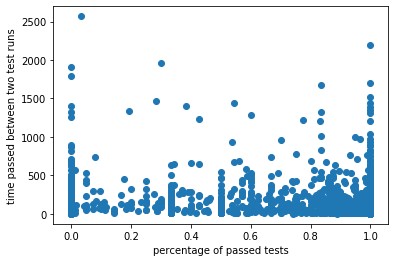

In [299]:
edits_tests_array = np.array(edits_tests, dtype="O")

x = edits_tests_array[:,3] # time passed between two test runs
y = edits_tests_array[:,5] # ratio

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(y,x)
plt.ylabel('time passed between two test runs') 
plt.xlabel('percentage of passed tests') 
plt.plot(yfit, xfit);
y_pred = model.predict(x_test[:, np.newaxis])

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.3f" % mse)
print('r2 score: %.3f' % r2_score(y_test, y_pred))

INTERPRETATION

Mean squared error: 0.150
r2 score: 0.001


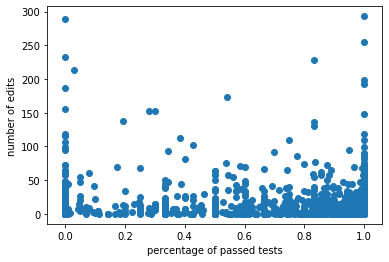

In [284]:
x = edits_tests_array[:,4] # nr of edits
y = edits_tests_array[:,5] # ratio

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(y,x)
plt.xlabel('percentage of passed tests') 
plt.ylabel('number of edits') 
plt.plot(yfit, xfit);
y_pred = model.predict(x_test[:, np.newaxis])

print("Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
print('r2 score: %.3f' % r2_score(y_test, y_pred))

TODO: write interpretation

In [146]:
# Machine Learning Alogrithm
def MLRegressor(x,y):
    classifiers = [("KNN", KNeighborsRegressor(3)),
                   ("DecisionTree", DecisionTreeRegressor(max_depth=5)),
                   ("SVM_RBF", SVR(kernel='rbf', C=1, gamma=0.1, epsilon=.1))]
    for name,model in classifiers:
        Acc = []
        MSE = []
        RMSE = []
        kf = KFold(n_splits = 5, shuffle = True)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit = model.fit(x_train, y_train)
            Acc.append(r2_score(y_test, model.predict(x_test)))
            MSE.append(mean_squared_error(y_test, model.predict(x_test)))
            RMSE.append(np.sqrt(mean_squared_error(y_test, model.predict(x_test))))
            
        print("The model performance for ",name)
        print("-------------------------------------------")
        print("R-Squared Score for ", name, "is", np.mean(Acc))
        print("MSE Value for ", name, "is", np.mean(MSE))
        print("RMSE Value for ", name, "is", np.mean(RMSE))
        print("\n")

In [147]:
edits_tests_array = np.array(edits_tests, dtype="O")

x = edits_tests_array[:,3] # time passed between two test runs
y = edits_tests_array[:,5] # ratio

MLRegressor(x,y)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [144]:
def MLClassifier(x,y):
    classifiers = [("KNN", KNeighborsClassifier(5)),
                   ("DecisionTree", DecisionTreeClassifier(max_depth=5)),
                   ("Logistic", LogisticRegression()),
                   ("Linear", SGDClassifier())]
    for name,model in classifiers:
        Acc = []
        kf = KFold(n_splits = 5, shuffle = True)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit = model.fit(x_train, y_train)
            Acc.append(accuracy_score(y_test, model.predict(x_test), normalize = True))

        print("Accuracy Score for ", name, "is", np.mean(Acc))
        print("-------------------------------------------")

In [145]:
edits_tests_array = np.array(edits_tests, dtype="O")

x = edits_tests_array[:,4] # booleanNextResult, test pass or fail
y = edits_tests_array[:,5] # ratio
MLClassifier(x,y)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

We create a logistic regression to model the probability of successful tests.

In [278]:
Y = df_edits_tests["nextTestResult"]
X = df_edits_tests[["editsUntilNextTest",'timePassed']]
X1 = sm.add_constant(X)
logit_model = sm1.Logit(Y, X1)
result_logit_model = logit_model.fit()
print(result_logit_model.summary2())
print(f' The correlation between the two independent variables is {round(df_edits_tests["editsUntilNextTest"].corr(df_edits_tests["timePassed"]),2)}')

Optimization terminated successfully.
         Current function value: 0.474849
         Iterations 5
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.001    
Dependent Variable:  nextTestResult   AIC:              1920.5907
Date:                2020-06-01 13:29 BIC:              1937.4173
No. Observations:    2016             Log-Likelihood:   -957.30  
Df Model:            2                LL-Null:          -958.05  
Df Residuals:        2013             LLR p-value:      0.47061  
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      5.0000                                      
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
const               1.5461   0.0696 22.2071 0.0000  1.4096 1.6825
editsUntilNextTest  0.0030   0.0049  0.6068 0.5440 -0.0066 0.0125


In [280]:
X_edit = df_edits_tests[["editsUntilNextTest"]]
X1_edit = sm.add_constant(X_edit)
logit_model_edit = sm1.Logit(Y, X1_edit)
result_logit_model_edit = logit_model_edit.fit()
print(result_logit_model_edit.summary2())

Optimization terminated successfully.
         Current function value: 0.475126
         Iterations 5
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.000    
Dependent Variable:  nextTestResult   AIC:              1919.7084
Date:                2020-06-01 13:30 BIC:              1930.9262
No. Observations:    2016             Log-Likelihood:   -957.85  
Df Model:            1                LL-Null:          -958.05  
Df Residuals:        2014             LLR p-value:      0.53245  
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      5.0000                                      
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
const               1.5152   0.0631 23.9956 0.0000  1.3915 1.6390
editsUntilNextTest -0.0015   0.0023 -0.6360 0.5248 -0.0059 0.0030


In [281]:
X_time = df_edits_tests[["timePassed"]]
X1_time = sm.add_constant(X_time)
logit_model_time = sm1.Logit(Y, X1_time)
result_logit_model_time = logit_model_time.fit()
print(result_logit_model_time.summary2())

Optimization terminated successfully.
         Current function value: 0.474943
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.001    
Dependent Variable: nextTestResult   AIC:              1918.9696
Date:               2020-06-01 13:31 BIC:              1930.1873
No. Observations:   2016             Log-Likelihood:   -957.48  
Df Model:           1                LL-Null:          -958.05  
Df Residuals:       2014             LLR p-value:      0.28808  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
-----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
-----------------------------------------------------------------
const          1.5381    0.0684  22.4944  0.0000   1.4041  1.6721
timePassed    -0.0003    0.0002  -1.0875  0.2768  -0.0007  0.0002

